In [1]:
include("../src/ccgsemparser/semantic_parser.jl")
import PyCall: PyReverseDims
import PyPlot
import StaticArrays: @SArray, SVector
import Base.Iterators: product
import MetaGraphs: get_prop, set_prop!, nv, edges
import GenSceneGraphs: SceneGraph, addObject!, setPose!, setContact!, Box, scaleBox, setDiagnosticViz!,
                       renderScene, Pose, CameraConfig, LightingConfig, ViewSpec, 
                       compileContactGraph!, getContactPlane, getAbsolutePose, cameraConfigFromAngleAspect,
                       convertSceneGraphToGraphViz
import GenSceneGraphs.YCB: mustardBottle, crackerBox, sugarBox, pottedMeatCan, tomatoSoupCan, gelatinBox,
                           bleachCleanser, origSizeCm, conventionalTop, conventionalBottom, conventionalFront,
                           conventionalBack, setAssetDir;

pybullet build time: Aug 12 2020 21:26:20


In [2]:
import .CCGSemanticParser.CCGs: CombinatoryCategorialGrammar, Lexicon,
                                factored_lexical_entries,
                                factored_type_shifting_rules,
                                LexicalEntry, Category, chart_parse,
                                category, logical_form, syntactic_type,
                                @primitive_syntactic_type
                   
import .CCGSemanticParser.CCGVis: render_parse_tree_latex
import .CCGSemanticParser.LambdaCalculus: @variable, @constant, lambda, ≃, Constant, lambda_reduce
import .CCGSemanticParser.LambdaLogic: @predicate, and, Model, assert!, constants,
                                       interpret, yes, no, has_constant, add_constant!

λ = lambda; # aesthetics

In [3]:
setAssetDir("/GenSceneGraphs/src/assets/ycb/models"); # XXX use your local path

## The Grammar

In [4]:
@primitive_syntactic_type NP N PP
@variable x y f

@constant box can bottle meat soup sugar gelatin mustard cracker bleach 

@predicate Shape Content 2
@predicate OnTopOf Underneath RightOf LeftOf InFrontOf Behind 2;

In [5]:
relation_lexemes = [("on top of", (OnTopOf,)),
                    ("underneath", (Underneath,)),
                    ("behind", (Behind,)),
                    ("in front of", (InFrontOf,)),
                    ("on the right of", (RightOf,)),
                    ("on the left of", (LeftOf,))]
relation_left_template(pred) = Category((NP/NP)\NP, λ(f, λ(y, λ(x, and(f(x), pred(x, y))))))
relation_right_template(pred) = Category(PP/NP, λ(y, λ(x, pred(x, y))))

object_lexemes = [("meat can", (meat, can)), ("soup can", (soup, can)),
                 ("sugar box", (sugar, box)), ("gelatin box", (gelatin, box)),
                 ("mustard bottle", (mustard, bottle)), ("bleach bottle", (bleach, bottle)),
                 ("cracker box", (cracker, box))]
object_template(content, shape) = Category(N, λ(x, and(Shape(x, shape), Content(x, content))))
object_modified_template(content, shape) = Category(N/PP,
    λ(f, λ(x, and(f(x), Shape(x, shape), Content(x, content)))))

bare_object_lexemes = [("box", (box,)), ("can", (can,)), ("bottle", (bottle,))]
bare_object_template(shape) = Category(N, λ(x, Shape(x, shape)))
bare_object_modified_template(shape) = Category(N/PP, λ(f, λ(x, and(Shape(x, shape), f(x)))))

lexicon = Lexicon([
    LexicalEntry("a", NP/N, λ(x, x)),
    factored_lexical_entries(relation_lexemes, relation_left_template)...,
    factored_lexical_entries(relation_lexemes, relation_right_template)...,
    factored_lexical_entries(object_lexemes, object_template)...,
    factored_lexical_entries(object_lexemes, object_modified_template)...,
    factored_lexical_entries(bare_object_lexemes, bare_object_template)...,
    factored_lexical_entries(bare_object_lexemes, bare_object_modified_template)...,
])

type_shifting_rules = Dict{String, Vector{Category}}()

grammar = CombinatoryCategorialGrammar(lexicon, type_shifting_rules);

In [6]:
import .CCGSemanticParser.CCGs: type_shifted_lexical_entries,
                                InvalidCCGOperation, Left, Right,
                                apply, compose, lexeme,
                                CCGParseTreeNode, CCGParseTreeLeaf,
                                BinaryInternalNode,
                                cat_combinations, left_child,
                                right_child, lexical_entry, tokenize,
                                syntactic_type, ComplexSyntacticType,
                                arg, res, agrees, compose,
                                CategoryComposition, CategoryApplication

In [7]:
get_sentence(leaf::CCGParseTreeLeaf) = lexeme(lexical_entry(leaf))
get_sentence(node::BinaryInternalNode) = join(map(f->get_sentence(f(node)), (left_child, right_child)), " ")

get_sentence (generic function with 2 methods)

In [8]:
function LR_parse(sentence)
    fringe = [CCGParseTreeLeaf(LexicalEntry("a", NP/N, λ(x, x)))]
    leaves = map(CCGParseTreeLeaf, type_shifted_lexical_entries(grammar))
    evidence = "a"
    for token in tokenize(sentence, grammar)[2:end]
        new_fringe = []
        evidence *= " " * token
        while !isempty(fringe)
            state = pop!(fringe)
            for leaf in leaves
                new_combinations = filter(pt->(get_sentence(pt) == evidence),
                                          cat_combinations(state, leaf))
                append!(new_fringe, new_combinations)
            end
        end
        fringe = new_fringe
    end
    fringe
end

LR_parse (generic function with 1 method)

In [9]:
function unique_forms(parses, criterion=t->true)
    valid_parses = filter(criterion, parses);
    forms = []
    for form in map(logical_form ∘ category, valid_parses)
        if all(f->!(f ≃ form), forms)
            push!(forms, form)
        end
    end
    forms
end;

In [10]:
unique_forms(LR_parse("a sugar box behind a meat can on top of a mustard bottle"),
             pt->syntactic_type(category(pt)) == NP)

2-element Array{Any,1}:
 λx.((Shape x box)∧(Content x sugar)∧(Behind x λx.((OnTopOf x λx.((Shape x bottle)∧(Content x mustard)))∧(Shape x can)∧(Content x meat))))
 λx.((Shape x box)∧(Content x sugar)∧(Behind x λx.((Shape x can)∧(Content x meat)))∧(OnTopOf x λx.((Shape x bottle)∧(Content x mustard))))

# The Scene

In [11]:
import Rotations: RotMatrix

In [12]:
CAMERA_HEIGHT = 15.0
CAMERA_ANGLE = 0.0
CAMERA_DIST_FROM_ORIGIN = 30.0
CELL_EDGE_LENGTH = 3.5
FLOOR_SIZE = 100.0
EPSILON = 1e-3
YCB_OBJECTS = [mustardBottle, crackerBox, sugarBox, pottedMeatCan, tomatoSoupCan, gelatinBox, bleachCleanser]
YCB_COLORS =  [:goldenrod, :crimson, :yellow, :blue, :maroon, :DarkOrange, :white];

In [13]:
ycb_name(ycb_object) = split(string(ycb_object), '.')[end][1:end-2]
ycb_color(ycb_object) = YCB_COLORS[findfirst(isequal(ycb_object), YCB_OBJECTS)];

In [14]:
function floor_contact_params(row, col, θ, nrows, ncols)
    scene_length, scene_width = CELL_EDGE_LENGTH .* [ncols, nrows]
    (scene_length / (2ncols) * (2col - 1 - ncols),
        -scene_width / (2nrows) * (nrows + 1 - 2row), θ)
end

function scene_description_to_scene_graph(descr::Dict; bbox_only=false)
    g = SceneGraph()
    addObject!(g, :floor, Box(FLOOR_SIZE, FLOOR_SIZE, 1.))
    setPose!(g, :floor, [0., 0., -0.5], (yaw=0, pitch=0, roll=0))
    obj_at_coord, nrows, ncols = Dict(), descr[:nrows], descr[:ncols]
    for i=1:Int(descr[:nobjs])
        obj_type, (x, y), θ = map(s->descr[:objs => i => s], (:obj_type, :grid_coords, :contact_angle))
        name = Symbol(ycb_name(obj_type), i)
        parent, parent_contact_plane = get(obj_at_coord, (x, y), (:floor, :top))
        contact_params = parent == :floor ? floor_contact_params(y, x, θ, nrows, ncols) : (0, 0, θ)
        addObject!(g, name, scaleBox(origSizeCm(obj_type), 0.2))
        if bbox_only
            setDiagnosticViz!(g, name, bbox=true, color=ycb_color(obj_type))
        end
        setContact!(g, parent, parent_contact_plane, (), name, conventionalBottom(obj_type), (), contact_params...)
        obj_at_coord[(x, y)] = (name, conventionalTop(obj_type))
    end
    return g
end;

In [15]:
cross(v::SVector{3}, u::SVector{3}) = 
    @SArray([v[2]*u[3]- v[3]*u[2], v[3]*u[1] - v[1]*u[3], v[1]*u[2] - v[2] * u[1]]);

In [16]:
normalize_euc(v::AbstractArray{T}) where {T<:Real} = v ./ sqrt(sum(v.^2));

In [17]:
function project_on_plane(obj::Pose, plane::Pose)
    p, n = plane.pos, plane.orientation[:, 3]
    obj.pos + ((p - obj.pos)' * n) * n
end;

In [18]:
function camera_eye_pose(dist_from_origin::Real, θ::Real, z::Real)
    R = dist_from_origin;
    eyeCoords = let r = sqrt(R^2 - z^2); @SArray([r*cos(θ), r*sin(θ), z]) end
    camFrameZdirection = let (x, y, z) = eyeCoords;
                             @SArray([-x*z, -y*z, x^2 + y^2]) end
    rotmat = hcat(normalize_euc.([-cross(eyeCoords, camFrameZdirection),
                                  -eyeCoords, camFrameZdirection])...)
    Pose(zeros(3), RotMatrix{3}(rotmat)) * Pose([0, -R, 0], one(RotMatrix{3}))
end

camera_eye_pose (generic function with 1 method)

In [55]:
function render_scene(scene::Dict; bbox_only=false, top=false)
    g = scene_description_to_scene_graph(scene; bbox_only=bbox_only)
    if top 
        camera_pose = camera_eye_pose(CAMERA_DIST_FROM_ORIGIN, CAMERA_ANGLE, CAMERA_HEIGHT)
    else
        camera_pose = camera_eye_pose(CAMERA_DIST_FROM_ORIGIN, CAMERA_ANGLE, 10)
    end
    camera = cameraConfigFromAngleAspect(
                      cameraEyePose=camera_pose,
                      fovDegrees=60.0, aspect=1.0, nearVal=0.01, farVal=50.0)
    lighting = LightingConfig(lightDirection=@SArray([-1, -2, -1]), ambientCoeff=1.2)
    rgba, = renderScene(g; width=512, height=512, view=ViewSpec(camera, lighting))
    PyReverseDims(permutedims(rgba, [3, 2, 1])) # XXX too hacky!
end;

In [56]:
# example scene in the slides
scene = Dict([
    :nobjs => 6,
    :nrows => 5,
    :ncols => 5,
    (:objs => (1 => :grid_coords)) => (5, 3),
    (:objs => (1 => :obj_type)) => crackerBox,
    (:objs => (1 => :contact_angle)) => π/4,
    (:objs => (2 => :grid_coords)) => (4, 3),
    (:objs => (2 => :obj_type)) => tomatoSoupCan,
    (:objs => (2 => :contact_angle)) => 0,
    (:objs => (3 => :grid_coords)) => (4, 4),
    (:objs => (3 => :obj_type)) => mustardBottle,
    (:objs => (3 => :contact_angle)) => 0,
    (:objs => (4 => :grid_coords)) => (2, 3),
    (:objs => (4 => :obj_type)) => mustardBottle,
    (:objs => (4 => :contact_angle)) => π/3,
    (:objs => (5 => :grid_coords)) => (2, 2),
    (:objs => (5 => :obj_type)) => pottedMeatCan,
    (:objs => (5 => :contact_angle)) => 6π/7,
    (:objs => (6 => :grid_coords)) => (3, 2),
    (:objs => (6 => :obj_type)) => sugarBox,
    (:objs => (6 => :contact_angle)) => 5π/7,
]);

In [64]:
scene_image = render_scene(scene; bbox_only=false)
scene_wireframe = render_scene(scene; bbox_only=true);

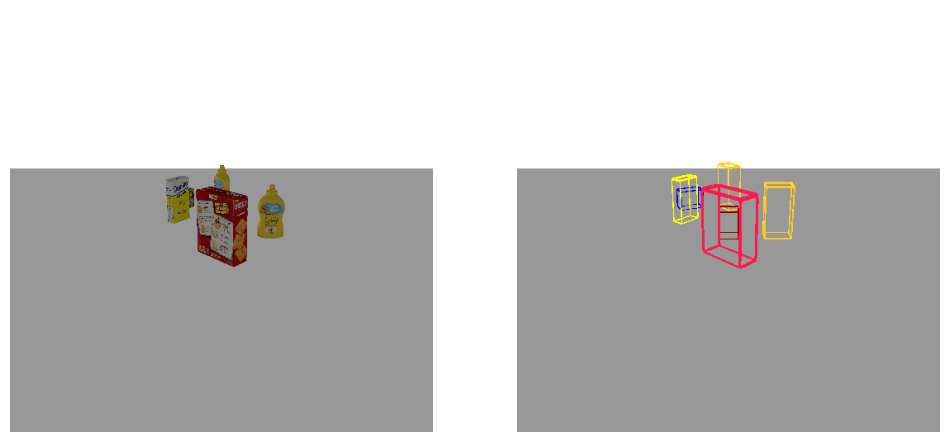

PyObject <matplotlib.image.AxesImage object at 0x7f8717219e48>

In [65]:
fig, axes = PyPlot.subplots(1, 2; figsize=(12, 6))
axes[1].axis("off")
axes[1].imshow(scene_image)
axes[2].axis("off")
axes[2].imshow(scene_wireframe)

# Knowledge Base

In [23]:
function compile_scene_to_camera_frame_poses!(scene::Dict)
    g = scene_description_to_scene_graph(scene)
    compileContactGraph!(g)
    camera_frame = camera_eye_pose(CAMERA_DIST_FROM_ORIGIN,
                                   CAMERA_ANGLE,
                                   CAMERA_HEIGHT)
    for v in 1:nv(g)
        set_prop!(g, v, :absolutePose, camera_frame \ get_prop(g, v, :absolutePose))
    end
    g
end

function add_spatial_relations!(m::Model, scene::Dict)
    g = compile_scene_to_camera_frame_poses!(scene)
    for extractor in (extract_xy, )#extract_z)
        for fact in extractor(g)
            assert!(m, fact)
        end
    end
end

function extract_z(g)
    vertex_names(edge) = map(v->Constant(get_prop(g, v, :name)),
                             (edge.dst, edge.src))
    [[OnTopOf(vertex_names(edge)...) for edge in edges(g) if !(:floor in vertex_names(edge))];
     [Underneath(reverse(vertex_names(edge))...) for edge in edges(g) if !(:floor in vertex_names(edge))]]
        
end

function extract_xy(g) 
    floor = get_prop(g, g[:floor, :name], :shape)
    floor_pose = get_prop(g, g[:floor, :name], :absolutePose)
    floor_plane = getContactPlane(floor, :top) * floor_pose
    floor_coords(obj) = project_on_plane(getAbsolutePose(g, obj), floor_plane)
    objs = map(v->get_prop(g, v, :name), 2:nv(g))
    [[RightOf(Constant(x), Constant(y)) for (x, y) in product(objs, objs)
          if EPSILON < floor_coords(x)[1] - floor_coords(y)[1]];
     [LeftOf(Constant(y), Constant(x)) for (x, y) in product(objs, objs)
          if EPSILON < floor_coords(x)[1] - floor_coords(y)[1]];
     [InFrontOf(Constant(x), Constant(y)) for (x, y) in product(objs, objs)
          if EPSILON < floor_coords(y)[2] - floor_coords(x)[2]];
     [Behind(Constant(y), Constant(x)) for (x, y) in product(objs, objs)
          if EPSILON < floor_coords(y)[2] - floor_coords(x)[2]]]
end

function add_object_descriptions!(m::Model, scene::Dict)
    content = Dict([mustardBottle => mustard, crackerBox => cracker, sugarBox => sugar,
                    pottedMeatCan => meat, tomatoSoupCan => soup, gelatinBox => gelatin,
                    bleachCleanser => bleach])
    shape = Dict([mustardBottle => bottle, crackerBox => box, sugarBox => box,
                    pottedMeatCan => can, tomatoSoupCan => can, gelatinBox => box,
                    bleachCleanser => bottle])
    for i=1:Int(scene[:nobjs])
        obj_type = scene[:objs=>i=>:obj_type]
        obj = Constant(Symbol(ycb_name(obj_type), i))
        assert!(m, Shape(obj, shape[obj_type]))
        assert!(m, Content(obj, content[obj_type]))
    end
end

function make_scene_model(scene::Dict)
    m = Model()
    add_object_descriptions!(m, scene)
    add_spatial_relations!(m, scene)
    foreach(c->add_constant!(m, c),
            filter(c->!has_constant(m, c),
                   [box, can, bottle, meat, soup, sugar, gelatin, mustard, cracker, bleach]))
    m
end

make_scene_model (generic function with 1 method)

# The Generative Model

In [24]:
using Gen

In [25]:
m = make_scene_model(scene);

In [26]:
@dist uniform_vector(vec::Vector) = vec[uniform_discrete(1, length(vec))];

In [27]:
struct PointMass{T} <: Distribution{T} end
point_mass(x::T) where T = (PointMass{T}())(x)
Gen.random(::PointMass{T}, support::T) where T = support
function Gen.logpdf(::PointMass{T}, choice::T, support::T) where T
    choice == support ? 0.0 : -Inf
end
(d::PointMass{T})(support::T) where T = random(d, support)

In [28]:
function is_semantically_valid(n::CCGParseTreeNode, target::Constant)
    if syntactic_type(category(n)) in (N, NP)
        res = interpret(m, logical_form(category(n)))(target)
    else
        unpred = lambda_reduce(logical_form(category(n))(λ(x, yes)))
        res = interpret(m, unpred)(target)
    end
    res
end

is_semantically_valid (generic function with 1 method)

In [29]:
@gen function generate_sentence(len::Int)
    target ~ uniform_vector([Constant(Symbol(ycb_name(scene[:objs => i => :obj_type]), i)) for i=1:scene[:nobjs]])
    state = nothing
    leaves = map(CCGParseTreeLeaf, type_shifted_lexical_entries(grammar))
    for i=1:len
        if i == 1
            state = ({:state => i} ~ (PointMass{CCGParseTreeNode}())(CCGParseTreeLeaf(LexicalEntry("a", NP/N, λ(x, x)))))
        else
            possible_combinations = filter(n->is_semantically_valid(n, target),
                                           vcat(map(n->cat_combinations(state, n), leaves)...))
            if isempty(possible_combinations)
                {:state => i} ~ (PointMass{CCGParseTreeNode}())(state)
            else
                state = ({:state => i} ~ uniform_vector(possible_combinations))
            end
        end
        {:emission => i} ~ (PointMass{String}())(get_sentence(state))
    end
end;

In [30]:
tr, w = generate(generate_sentence, (5,))
get_choices(tr)

│
├── :target : PottedMeatCan5
│
├── :emission
│   │
│   ├── 4 : a can behind a
│   │
│   ├── 2 : a can
│   │
│   ├── 3 : a can behind
│   │
│   ├── 5 : a can behind a box
│   │
│   └── 1 : a
│
└── :state
    │
    ├── 4 : BinaryInternalNode{Val{:composition},Val{:right}}(BinaryInternalNode{Val{:application},Val{:left}}(BinaryInternalNode{Val{:application},Val{:right}}(CCGParseTreeLeaf(LexicalEntry("a", Category(NP/N, λx.x))), CCGParseTreeLeaf(LexicalEntry("can", Category(N, λx.(Shape x can)))), Category(NP, λx.(Shape x can))), CCGParseTreeLeaf(LexicalEntry("behind", Category(NP/NP\NP, λf.λy.λx.((f x)∧(Behind x y))))), Category(NP/NP, λy.λx.((Shape x can)∧(Behind x y)))), CCGParseTreeLeaf(LexicalEntry("a", Category(NP/N, λx.x))), Category(NP/N, λy.λx.((Shape x can)∧(Behind x y))))
    │
    ├── 2 : BinaryInternalNode{Val{:application},Val{:right}}(CCGParseTreeLeaf(LexicalEntry("a", Category(NP/N, λx.x))), CCGParseTreeLeaf(LexicalEntry("can", Category(N, λx.(Shape x can)))), Category(NP

# Inference

In [84]:
function particle_filter(num_particles::Int, sentence::String)
    tokens = tokenize(sentence, grammar)
    evidence = tokens[1]
    init_obs = choicemap((:emission => 1, evidence))
    state = initialize_particle_filter(generate_sentence, (1,), init_obs, num_particles)
    # steps
    for t=2:length(tokens)
        visualize_particle_filter_state(state, evidence)
        maybe_resample!(state, ess_threshold=num_particles)
        evidence *= " " * tokens[t]
        obs = Gen.choicemap((:emission => t, evidence))
        particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return sample_unweighted_traces(state, num_particles)
end;

In [87]:
traces = particle_filter(100, "a can behind");

Dict{Any,Any}(CrackerBox1 => 14,PottedMeatCan5 => 12,SugarBox6 => 8,MustardBottle4 => 24,TomatoSoupCan2 => 18,MustardBottle3 => 24)
Dict{Any,Any}(PottedMeatCan5 => 46,TomatoSoupCan2 => 54)


# Visualization

In [81]:
function target_weights(particle_filter_state)
    target_weights = Dict()
    for tr in sample_unweighted_traces(particle_filter_state, 100)
        target_weights[tr[:target]] = get(target_weights, tr[:target], 0) + 1
    end
    target_weights
end

target_weights (generic function with 1 method)

In [86]:
function visualize_particle_filter_state(particle_filter_state, evidence)
    println(target_weights(particle_filter_state))
    #fig, axes = PyPlot.subplots(2, 2; figsize=(12, 12))
    #axes[1, 2].axis("off")
    #axes[2, 2].axis("off")
    #axes[1, 2].imshow(scene_image)
    #axes[2, 2].imshow(scene_wireframe)
end;

In [83]:
visualize_particle_filter_state(0, "a")

MethodError: MethodError: no method matching sample_unweighted_traces(::Int64, ::Int64)
Closest candidates are:
  sample_unweighted_traces(!Matched::Gen.ParticleFilterState{U}, ::Int64) where U at /root/.julia/packages/Gen/5JiNL/src/inference/particle_filter.jl:63